In [1]:
# XGBoost is very fast and accurate
# flow CART model ( Classification and regression Tree) 
# work good with continuous and categorical data
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings;warnings.filterwarnings('ignore');

# XGB Classification Model

In [2]:
# Reading Classification dataset and spliting into train and test
cancer = datasets.load_breast_cancer()
X,y = cancer.data,cancer.target

X_df = pd.DataFrame(X, columns= cancer.feature_names)
y_df = pd.DataFrame()
y_df['target'] = y.reshape(-1,1).flatten()

#df= pd.concat([X_df,y_df],axis=1)
#df.iloc[:,:-1],df.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state= 100,stratify=y)

In [3]:
import xgboost as xgb

xg_model = xgb.XGBClassifier(objective='binary:logistic',n_estimators=10, seed=123)
xg_model.fit(X_train, y_train)
preds = xg_model.predict(X_test)
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
score = xg_model.score(X_test,y_test)
print('Score : ', score)
print("accuracy: %f" % (accuracy))

Score :  0.9707602339181286
accuracy: 0.970760


In [4]:
# if we want to use XGB learner API modile. Convert data into DMatrix
# CV cross validation function provided by XGB learner API
cancer_dmatrix = xgb.DMatrix(data=X, label=y)
params = {"objective":"reg:logistic", "max_depth":7}
# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=cancer_dmatrix, params=params,nfold=3, num_boost_round=5,metrics="error", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)
print('Score : ' ,((1-cv_results["test-error-mean"]).iloc[-1]))

   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.020217         0.004992         0.065042        0.012498
1          0.014068         0.007571         0.065042        0.012498
2          0.010549         0.004314         0.056252        0.010004
3          0.007034         0.003294         0.058006        0.011422
4          0.004398         0.003291         0.054507        0.016374
Score :  0.9454933333333333


# XGB Regression Model

In [5]:
# 2 types of base learner tree and linear ( Linear is not common )
# 3 types of loss objective in sgb
### 1. reg:squarederror OR  reg:linear ( for regression models)
### 2. reg:logistic ( for classification not showing any probabilities of the class)
### 3. binary:logistic ( for showing probability in binary classification)

# Reading Regression data
boston = datasets.load_boston()
X,y = boston.data,boston.target
X_df = pd.DataFrame(X, columns= boston.feature_names)
X_df.head()

X_train, X_test, y_train, y_test = train_test_split(X_df, y,test_size=0.2,random_state= 100)

LINER BASE MODEL

In [6]:
# Liner base leraner in not present in Sciki learn so we have to use XGB lerners API 
# this model in not frequently used

#Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(X_train,label=y_train)
DM_test =  xgb.DMatrix(X_test,label=y_test)

params = {"booster":"gblinear", "objective":"reg:squarederror"}

xg_reg = xgb.train(params= params, dtrain=DM_train, num_boost_round=5)
y_pred = xg_reg.predict(DM_test)

# Compute and print the RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Linear base learner RMSE: %f" % (rmse))

Linear base learner RMSE: 7.673328


TREE BASE LEARNING MODEL

In [7]:
# booster = gbtree is by default

# Creating Regreesion Model
xg_reg = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=10, seed=123)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Tree base learner RMSE: %f" % (rmse))

Tree base learner RMSE: 3.682955


In [8]:
# Cross Validation

Boston_dmatrix = xgb.DMatrix(data=X, label=y)
params = {"objective":"reg:squarederror", "max_depth":8}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=Boston_dmatrix, params=params, nfold=4, num_boost_round=5, metrics='rmse', as_pandas=True, seed=123)

print(cv_results)


   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0        17.119631        0.057943       17.149926       0.293179
1        12.351691        0.035377       12.454320       0.344929
2         8.996692        0.038509        9.222034       0.287941
3         6.631964        0.036535        7.071121       0.312765
4         4.952979        0.030204        5.631795       0.327027


REGULARIZATION

In [9]:
# Regularization parameters in XGBoost:
# gamma - minimum loss reduction allowed for a split to occur
# alpha - l1 regularization on leaf weights, larger values meanmore regularization
# lambda - l2 regularization on leaf weights , not that severe

# Create the DMatrix: housing_dmatrix
reg_params = [0.001,0.1,1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective": "reg:squarederror", "max_depth": 4}
rmses_train_l2=[]
rmses_test_l2 =[]

for reg in reg_params:
    params["lambda"] = reg
    cv_results_rmse = xgb.cv(dtrain=Boston_dmatrix, params=params, nfold=2, num_boost_round=5, 
                             metrics="rmse", as_pandas=True, seed=123)

    rmses_test_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])
    rmses_train_l2.append(cv_results_rmse["train-rmse-mean"].tail(1).values[0])

print(pd.DataFrame(list(zip(reg_params, rmses_train_l2,rmses_test_l2)), columns=["l2", "rmse_train","ramse_test"]))


        l2  rmse_train  ramse_test
0    0.001    4.517497    5.525940
1    0.100    4.623264    5.529687
2    1.000    5.222681    6.007910
3   10.000    6.955846    7.216757
4  100.000   10.601924   10.692150


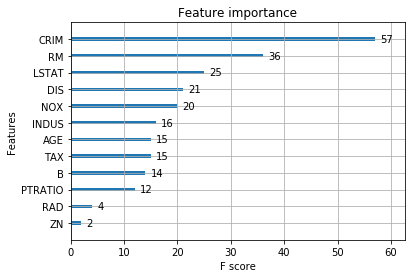

In [10]:
# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

# Hyper tunning 

In [11]:
# Common tree tunable parameterslearning rate: 
# learning rate/etagamma: min loss reduction to create new tree split ( between 0 and 1)
# lambda: L2 reg on leaf weights
# alpha: L1 reg on leaf weights
# max_depth: max depth per tree
# subsample: % samples used per tree ( between 0 and 1)
# colsample_bytree: % features used per tree ( between 0 and 1)

# Linear tunable parameters
# lambda: L2 reg on weights
# alpha: L1 reg on weights
# lambda_bias: L2 reg term on bias
# You can also tune the number of estimators used for both basemodel types!

In [12]:
# Grid Search CV
# All given conbinations are tested

# Create the parameter grid: gbm_param_grid
gbm_param_grid = {'colsample_bytree': [0.3,0.7],
                  'n_estimators': [50],
                  'max_depth': [2,5]
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor()

# Perform grid search: grid_mse
from sklearn.model_selection import GridSearchCV
grid_mse = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid,scoring='neg_mean_squared_error',verbose=1,cv=4)

grid_mse.fit(X,y)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best parameters found:  {'colsample_bytree': 0.7, 'max_depth': 2, 'n_estimators': 50}
Lowest RMSE found:  4.709864996540573


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.6s finished


In [13]:
# Random Search CV
# you have to provide number of iteration to run and it run accordingly on provided options of paratmeters

# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {'n_estimators': [25,50],
                  'max_depth':range(2,12)
}

# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(n_estimators=10)

# Perform random search: grid_mse
from sklearn.model_selection import RandomizedSearchCV
randomized_mse = RandomizedSearchCV(estimator=gbm,param_distributions=gbm_param_grid,
                                    verbose=1,cv=4,n_iter = 5,scoring="neg_mean_squared_error")


randomized_mse.fit(X,y)
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best parameters found:  {'n_estimators': 50, 'max_depth': 3}
Lowest RMSE found:  4.4043902657634915


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.0s finished


# Pipeline with Random search

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

steps= [("st_scaler",StandardScaler()),
        ("xgb_model",xgb.XGBRegressor())]

xgb_pipeline = Pipeline(steps)

In [15]:
# Parameters for random search

gbm_param_grid = {'xgb_model__subsample': np.arange(.05, 1, .025),
                  'xgb_model__max_depth': np.arange(2,20,1),
                  'xgb_model__colsample_bytree': np.arange(.1,1.05,.05) }

In [16]:
# Model
randomized_neg_mse = RandomizedSearchCV(estimator=xgb_pipeline,param_distributions=gbm_param_grid,
                                        n_iter=50,scoring='neg_mean_squared_error', cv=4)


randomized_neg_mse.fit(X,y)

# Compute metrics
print(round(np.sqrt(np.abs(randomized_neg_mse.best_score_)),2))
print(randomized_neg_mse.best_estimator_)

4.72
Pipeline(memory=None,
     steps=[('st_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('xgb_model', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9500000000000003, gamma=0,
       gpu_id=-1, importance_type='gain', interaction_constraints..., subsample=0.6000000000000002,
       tree_method='exact', validate_parameters=1, verbosity=None))])
